<a href="https://colab.research.google.com/github/kechase/Chase_DSPN_S25/blob/main/ExerciseSubmissions/KChase_Exercise_9_Classification_classifiers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Exercise 9: Classification

1. Loading and formatting the data 1/1
2. Visualizing the data 1/1
3. Logisic Regression: Fitting the model 2/2
4. Interpreting predictions from the model 3/3
5. QDA 3/3

This homework assignment is designed to give you practice with classification models. We'll try to predict which words are more likely to be responded to correctly during a lexical decision task, based on their length and frequency.

We will be using data from the English Lexicon Project again. However, this time we will use response correctness as our dependent variable. Load **LexicalData_withIncorrect.csv**, which includes incorrect trials as well as correct ones, and also **Items.csv**. Both can be found in the *Homework/lexDat* folder in the class GitHub repository.

This data is a subset of the [English Lexicon Project database](https://elexicon.wustl.edu/). It provides response correctness and reaction times (in milliseconds) of many subjects as they are presented with letter strings and asked to decide, as quickly and as accurately as possible, whether the letter string is a word or not. The **Items.csv** provides characteristics of the words used, namely frequency (how common is this word?) and length (how many letters?).

*Data courtesy of Balota, D.A., Yap, M.J., Cortese, M.J., Hutchison, K.A., Kessler, B., Loftis, B., Neely, J.H., Nelson, D.L., Simpson, G.B., & Treiman, R. (2007). The English Lexicon Project. Behavior Research Methods, 39, 445-459.*

---
## 1. Loading and formatting the data (1 point)

Load in data from the **LexicalData_withIncorrect.csv** and **Items.csv** files. Use `left_join` to add word characteristics `Length` and `Log_Freq_Hal` from **Items** to the **LexicalData**, and use `drop_na()` to get rid of any observations with missing values. Then use `head()` to look at the first few rows of the data.

*Note: We're just working with `Correct` in this homework, so no need to worry about reformatting reaction times.*

In [ ]:
# Load the packages
library(tidyverse)
library(dplyr)

# Install and load necessary libraries
install.packages("googledrive")
library(googledrive)

# Authenticate (will prompt for authorization)
drive_auth()

# Download first file
drive_download(
  as_id("1U8C-H2-5boqqOhcvgPb_1CRNCyfvGJykN-7TEx3Lpxc"),
  path = "LexicalData_withIncorrect.csv",
  overwrite = TRUE
)

# Download second file
drive_download(
  as_id("1hVevzJeLsrm3DBsly9C4pEsXCSbyAihlNv-9WWUparw"),
  path = "Items.csv",
  overwrite = TRUE
)

# Read CSV file into a variable
lex_data_withIncorrect <- read.csv("LexicalData_withIncorrect.csv")
items <- read.csv("Items.csv")

# Look at column names to ensure using the right ones
colnames(lex_data_withIncorrect)
colnames(items)
items <- items %>% select(Word, Length, Log_Freq_HAL)
colnames(items)

# Join datasets
word_data <- lex_data_withIncorrect %>%
  left_join(items, by = c("D_Word" = "Word")) %>%
  drop_na()

head(word_data)



Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

The googledrive package is requesting access to your Google account.
Enter '1' to start a new auth process or select a pre-authorized account.
1: Send me to the browser for a new auth process.
2: katiechasemusic@gmail.com


Selection: 2


Auto-refreshing stale OAuth token.

File downloaded:

• LexicalData_withIncorrect <id: 1U8C-H2-5boqqOhcvgPb_1CRNCyfvGJykN-7TEx3Lpxc>

Saved locally as:

• LexicalData_withIncorrect.csv

File downloaded:

• Items <id: 1hVevzJeLsrm3DBsly9C4pEsXCSbyAihlNv-9WWUparw>

Saved locally as:

• Items.csv



[1] "X"        "Sub_ID"   "Trial"    "Type"     "D_RT"     "D_Word"   "Outlier" 
[8] "D_Zscore" "Correct"

[1] "Occurrences"  "Word"         "Length"       "Freq_HAL"     "Log_Freq_HAL"

[1] "Word"         "Length"       "Log_Freq_HAL"

,X,Sub_ID,Trial,Type,D_RT,D_Word,Outlier,D_Zscore,Correct,Length,Log_Freq_HAL
,<int>,<int>,<int>,<int>,<chr>,<chr>,<lgl>,<dbl>,<int>,<int>,<dbl>
1,1,157,1,1,710,browse,FALSE,-0.437,1,6,8.856
2,2,67,1,1,"1,094",refrigerant,FALSE,0.825,1,11,4.644
3,3,120,1,1,587,gaining,FALSE,-0.645,1,7,8.304
4,4,21,1,1,984,cheerless,FALSE,0.025,1,9,2.639
5,5,236,1,1,577,pattered,FALSE,-0.763,1,8,1.386
6,6,236,2,1,715,conjures,FALSE,-0.364,1,8,5.268


---
## 2. Visualizing the data (1 point)

First, we'll try to visualize whether trials that are responded to correctly versus incorrectly differ from each other in terms of word length and log frequency. The code is included below, so that this homework doesn't get too cumbersome. All you have to do is **change the name of the data set**, **run the code**, and **write some observations about the output**.

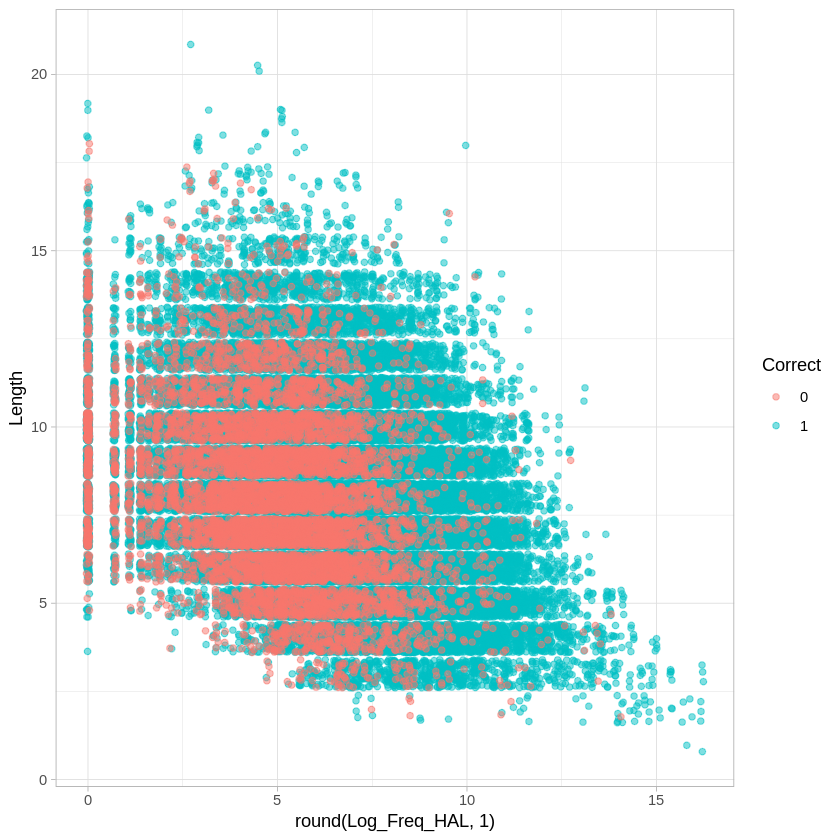

In [ ]:
require(tidyverse) # Load the tidyverse package, if you haven't yet
word_data$Correct <- as.factor(word_data$Correct) # so that R knows that Correct is categorical, not numeric.

# plot the Correct / Incorrect clusters
ggplot(word_data,aes(x=round(Log_Freq_HAL,1),y=Length,col=Correct)) + geom_point(position="jitter",alpha=0.5) + theme_light()


What do you observe about the "Correct" and "Incorrect" clusters?

> *The x-axis is noting frequency of words in the data set and the y-axis is noting the length of each of those words. The legend "Correct" identifies 0 as incorrectly identified by the participant and 1 as correctly identified. The teal plots, noting correctly identified, extend further in both directions of frequency and word length. The red-orange, 0, notes the incorrect responses, with those clustered around both less frequent and slighly shorter words than the correct answers. The area of incorrect answers overlaps with correct answers; however, the higher frequency and longer length seem more likely to be correctly identified.*
>

---
## 3. Logistic Regression: Fitting the model (2 points)

Fit a logistic regression model to the data using `Length`, `Log_Freq_HAL`, and their interaction to predict `Correct`. Use `glm()` to fit the model, and look at its output using `summary()`.

In [ ]:
glm_model <- glm(Correct ~ Length * Log_Freq_HAL,
             data = word_data,
             family = binomial)

summary(glm_model)




Call:
glm(formula = Correct ~ Length * Log_Freq_HAL, family = binomial, 
    data = word_data)

Coefficients:
                     Estimate Std. Error z value Pr(>|z|)    
(Intercept)         -0.939996   0.115623  -8.130 4.30e-16 ***
Length               0.151266   0.012789  11.828  < 2e-16 ***
Log_Freq_HAL         0.394772   0.018762  21.041  < 2e-16 ***
Length:Log_Freq_HAL -0.010558   0.002202  -4.795 1.63e-06 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 49809  on 70588  degrees of freedom
Residual deviance: 46563  on 70585  degrees of freedom
AIC: 46571

Number of Fisher Scoring iterations: 5


What can you conclude from this output? (a brief gist is fine)

> *Based on extremely small p-values for length and frequency these are significant predictors of correct answers. The interaction is also significant and, with a negative coefficient, means factored together they slighly reduce their overall effect.*
>

---
## 4. Interpreting predictions from the model (3 points)

Finally, look at how well this logistic regression model does at predicting correctness. Use `predict()` and a threshold of 0.5 to generate predicted `Correct` values for each trial, then output a confusion matrix and overall accuracy for these predictions.

*Hint: see the Classifiers tutorial.*

In [ ]:
install.packages("ISLR")
library(ISLR)
library(ggplot2)

# Generate predicted probabilities
predict_prob <- predict(glm_model, type = "response")
# Convert to binary predictions
predict_df <- data.frame(
  predict_prob = predicted_prob,
  predict_binary = ifelse(predict_prob >= 0.5, 1.0, 0),
  actual = word_data$Correct
)

head(predictions_df)

# Create a confusion matrix
conf_matrix <- table(Predicted = predict_df$predict_binary, Actual = predict_df$actual)
print("Confusion Matrix:")
print(conf_matrix)

# Calculate accuracy
accuracy <- sum(diag(conf_matrix)) / sum(conf_matrix)
print(paste("Accuracy:", round(accuracy * 100, 2), "%"))


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



,predicted_prob,predicted_binary,actual
,<dbl>,<dbl>,<fct>
1,0.9479784,1,1
2,0.8826628,1,1
3,0.9417677,1,1
4,0.7707288,1,1
5,0.6682356,1,1
6,0.8704362,1,1


[1] "Confusion Matrix:"
         Actual
Predicted     0     1
        0    13    44
        1  7966 62566
[1] "Accuracy: 88.65 %"


Did the model do well at predicting lexical decision correctness? Why or why not?

> *The model does well at predicting whether or not a word will be chosen as correct or incorrect; 88% is significantly above chance. It does however have a fair number of false positives (44) and false positives (7966) but overall the model is strong.*  
>

## 5. QDA (3 points)

Load in the `MASS` library and fit a QDA model to the data set. The predictors are still `Length`, `Log_Freq_HAL`, and their interaction, just like the logistic regression model you just ran, and the dependent variable is still `Correct`.

*Hint: see the Classifiers tutorial.*

In [ ]:
# Install packages
install.packages("MASS")
install.packages("dplyr")

# Load library
library(MASS)
library(dplyr)

# Fit QDA model
qda_model <- qda(Correct ~ Length * Log_Freq_HAL, data = word_data)

# Print model summary
print(qda_model)



Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



Call:
qda(Correct ~ Length * Log_Freq_HAL, data = word_data)

Prior probabilities of groups:
        0         1 
0.1130346 0.8869654 

Group means:
    Length Log_Freq_HAL Length:Log_Freq_HAL
0 8.047124     4.932123            37.95260
1 7.979971     6.444849            49.34219


Now look at how well the predicted `Correct` values compare with actual `Correct` values for the whole data set. Output a confusion matrix and overall prediction accuracy.

In [ ]:
# Prediction model
qda_predictions <- predict(qda_model, word_data)

# Evaluate performance with confusion matrix
table(Actual = word_data$Correct, Predicted = qda_predictions$class)

# Calculate accuracy
accuracy <- mean(qda_predictions$class == word_data$Correct)
print(paste("Accuracy:", round(accuracy * 100, 2), "%"))





      Predicted
Actual     0     1
     0   455  7524
     1  1647 60963

[1] "Accuracy: 87.01 %"


How does QDA prediction performance differ from that of logistic regression?

> *The difference between the two models is approximately 1.6%, the quadratic discriminant analysis being the poorer predictor. Given the lower of the two models is still 87.01% accurate, they both demonstrate a strong ability to accurately predict the correct response.*
>

**DUE:** 5pm EST, March 11, 2024

**IMPORTANT** Did you collaborate with anyone on this assignment? If so, list their names here.
> *As always, worked with my coding tutor, claude.ai.*